Module pour Scrapper, (on peut aussi utiliser le truc std de python ie html_parser)

In [ ]:
!pip install lxml

# Données FBREF

Scrapper les données sur fbref (stats de tous les joueurs de PL)

In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import time


#Trouver le lien de toutes les équipes
toutes_les_equipes = []

html = requests.get('https://fbref.com/en/comps/9/Premier-League-Stats').text
soup = BeautifulSoup(html, 'lxml')
tableau = soup.find_all('table', class_='stats_table')[0]

liens = [lien.get("href") for lien in tableau.find_all('a') if '/squads/' in lien.get("href")]
urls_equipes = [f"https://fbref.com{lien}" for lien in liens]



#Pour chaque équipe extraire les stats de tous les joueurs
for url_equipe in urls_equipes:
    nom_equipe = url_equipe.split("/")[-1].replace("-Stats", "")
    html_equipe = requests.get(url_equipe).text
    soup_equipe = BeautifulSoup(html_equipe, 'lxml')
    tableau_stats = soup_equipe.find_all('table', class_='stats_table')[0]
    donnees_equipe = pd.read_html(str(tableau_stats))[0]
    donnees_equipe["Team"] = nom_equipe
    toutes_les_equipes.append(donnees_equipe)
    time.sleep(5)

df_statistiques = pd.concat(toutes_les_equipes)
df_statistiques.to_csv("Data_fbref.csv", index=False)

Chargement données

In [ ]:

df = pd.read_csv('Data_fbref.csv')
df.head()

Renommer les colonnes

In [ ]:


noms_colonnes = {
    'Unnamed: 0_level_0': 'Player',
    'Unnamed: 1_level_0': 'Nation',
    'Unnamed: 2_level_0': 'Pos',
    'Unnamed: 3_level_0': 'Age',
    'Unnamed: 4_level_0': 'MP',
    'Playing Time': 'Starts',
    'Playing Time.1': 'Min',
    'Playing Time.2': '90s',
    'Performance': 'Gls',
    'Performance.1': 'Ast',
    'Performance.2': 'G+A',
    'Performance.3': 'G-PK',
    'Performance.4': 'PK',
    'Performance.5': 'PKatt',
    'Performance.6': 'CrdY',
    'Performance.7': 'CrdR',
    'Expected': 'xG',
    'Expected.1': 'npxG',
    'Expected.2': 'xAG',
    'Expected.3': 'npxG+xAG',
    'Progression': 'PrgC',
    'Progression.1': 'PrgP',
    'Progression.2': 'PrgR',
    'Per 90 Minutes': 'Gls/90',
    'Per 90 Minutes.1': 'Ast/90',
    'Per 90 Minutes.2': 'G+A/90',
    'Per 90 Minutes.3': 'G-PK/90',
    'Per 90 Minutes.4': 'G+A-PK/90',
    'Per 90 Minutes.5': 'xG/90',
    'Per 90 Minutes.6': 'xAG/90',
    'Per 90 Minutes.7': 'xG+xAG/90',
    'Per 90 Minutes.8': 'npxG/90',
    'Per 90 Minutes.9': 'npxG+xAG/90',
    'Unnamed: 33_level_0': 'Matches',
    'Team': 'Team',
}



df=df.rename(noms_colonnes,axis='columns')
df.head()

Enlever la première ligne (pareil que noms colonnes)

In [ ]:
df=df.iloc[1:]
df.head()

Enlever le nombre de jours à l'âge

In [ ]:
sans_jours=lambda s : s.split('-')[0] if '-' in s else s
df['Age']=list(map(sans_jours,df['Age']))


Données propres sauvegardés

In [312]:
df.drop(columns='Unnamed: 0',inplace=True)
df.to_csv('/Users/Riyad/Documents/2A/Python_project/Data_fbref_cleaned.csv',index=False)

# Données Sofascore

Trouver le bon championnat et saison

In [ ]:
import requests


BASE_URL = "https://api.sofascore.com/api/v1"

def get_championnats(language="en", sport="football"):
    url = f"{BASE_URL}/config/unique-tournaments/{language}/{sport}"
    response = requests.get(url)
    response.raise_for_status()
    return response.json()["uniqueTournaments"]

def get_saisons(tournament_id):
    url = f"{BASE_URL}/unique-tournament/{tournament_id}/seasons"
    response = requests.get(url)
    response.raise_for_status()
    return response.json()["seasons"]



championnats = get_championnats()
premier_league = next(t for t in championnats if t["name"] == "Premier League")
pl_id = premier_league["id"]

saisons = get_saisons(pl_id)
saison = saisons[0]  
s_id = saison["id"]





Trouver les ids de toutes les équipes

In [ ]:
url = f"https://api.sofascore.com/api/v1/unique-tournament/{pl_id}/season/{s_id}/teams"

response = requests.get(url)
response.raise_for_status()  


data = response.json()


equipe_ids=dict([(data['teams'][i]['name'],data['teams'][i]['id']) for i in range(len(data['teams']))])
equipe_ids

Récupération des ID de tous les joueurs

In [536]:
url = f"https://api.sofascore.com/api/v1/team/42/players"
response = requests.get(url)
response.raise_for_status() 



data = response.json()

In [ ]:

joueur_ids={}

for k,v in equipe_ids.items(): 
    url = f"https://api.sofascore.com/api/v1/team/{v}/players"
    response = requests.get(url)
    response.raise_for_status() 

    
    
    data = response.json()
    
    player_id_team={}
    seen=set()
    for player_type in ['players','foreignPlayers','nationalPlayers']:
        for i in range(len(data[player_type])):
            s=data[player_type][i]['player']['name']
            if s not in seen:
                player_id_team[data[player_type][i]['player']['name']]=data[player_type][i]['player']['id']
                seen.add(s)
    
    
    joueur_ids[k]=player_id_team
    
joueur_ids


Récupération des stats de chaque joueur

In [ ]:
df={}

for k,v in joueur_ids.items():
    
    for kk,vv in v.items():
        url = f"https://api.sofascore.com/api/v1/player/{vv}/unique-tournament/{pl_id}/season/{s_id}/statistics/overall"


        
        
        response = requests.get(url)
        
        try:
            response.raise_for_status() 
            
            data = response.json()
            data=data['statistics']
            df[kk]={}
            for kkk,vvv in data.items():
                df[kk][kkk]=vvv
        except:
            print(kk + ' pas trouvé')

df

In [569]:
df=pd.DataFrame(df)
df=df.transpose()


In [574]:
#df=df.drop('Unnamed: 0',axis=1)
df.to_csv('Data_sofascore.csv',index=True)

# Données Transfermarket

## Données sur les joueurs

(On récupère taille + valeur marchande + postes)

In [ ]:
!pip install selenium
!pip install webdriver_manager

In [594]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

def joueur_url(nom_joueur, driver):
    
    url = f"https://www.transfermarkt.com/schnellsuche/ergebnis/schnellsuche?query={nom_joueur}&x=0&y=0"
    driver.get(url)
    time.sleep(2)  

    try:
        liens_joueurs = driver.find_elements(By.CSS_SELECTOR, "a[href*='/profil/spieler/']")
        
        

        return liens_joueurs[0].get_attribute("href")
    except Exception as e:
        print(f"Error: {e}")
        return None


Retirer accents de BD

In [586]:
import unicodedata

def retirer_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

df_fbref=pd.read_csv('/Users/Riyad/Documents/2A/Python_project/Data_fbref_cleaned.csv')
#df_sf=pd.read_csv('/Users/Riyad/Documents/2A/Python_project/Data_sofascore.csv')


for i in range(len(df_fbref.index)):
    df_fbref.loc[i,'Player']=retirer_accents(df_fbref.loc[i,'Player'])
for i in range(len(df_sf.index)):
    df_sf.loc[i,'Player']=retirer_accents(df_sf.loc[i,'Player'])



In [584]:
df_sf=df_sf.rename(lambda s:'Player' if s=='Unnamed: 0' else s,axis=1)

In [ ]:
df_sf=df_sf.rename(columns=lambda x:'Player' if x=='Unnamed: 0' else x)
df_fbref.to_csv('/Users/Riyad/Documents/2A/Python_project/Data_fbref_cleaned.csv')
df_sf.to_csv('/Users/Riyad/Documents/2A/Python_project/Data_sofascore.csv')


In [ ]:

driver = webdriver.Chrome()
driver.implicitly_wait(10)

#tmrkt_data={}
    
def positions(driver):
    try:
        
        positions = driver.find_elements(
            By.XPATH,"//dd[@class='detail-position__position']"
        )
        
        
        
        positions = [element.text.strip() for element in positions if element.text.strip()]
        
        
        if not positions:
            print("Pas de positions trouvées.")
        else:
            print(f"Positions: {positions}")
        return positions
            

    except Exception as e:
        print(f"Erreur en cherchant les postes: {e}")

def valeur(driver):
    try:
        valeur = driver.find_element(By.CSS_SELECTOR, "a.data-header__market-value-wrapper")
        return valeur.text
    except Exception as e:
        print(f"Erreur en cherchant la valeur: {e}")
        return None

def taille(driver):
    try:
        taille = driver.find_element(By.CSS_SELECTOR, "span[itemprop='height'].data-header__content")
        return taille.text.strip()
    except Exception as e:
        print(f"Erreur en cherchant la taille: {e}")
        return None

for joueur in df_sf['Player']:
    if joueur not in tmrkt_data.keys() or None in tmrkt_data[joueur]:
        url = joueur_url(joueur, driver)
        if url:
            driver.get(url)
            time.sleep(1)  # Optional: Allow the page to settle
            tmrkt_data[joueur] = [
                valeur(driver),
                positions(driver),
                taille(driver),
            ]
        else:
            print(f"Pas trouvé l'url de {joueur}")

driver.quit()
import pickle
with open("transfermarket_data.pkl", "wb") as file:
    pickle.dump(tmrkt_data, file)



In [602]:
tmrkt_data=pd.DataFrame(tmrkt_data)
tmrkt_data=tmrkt_data.transpose()
tmrkt_data.columns=['Value','Positions','Height']
tmrkt_data.loc[:,'Value']=[x.split('\n')[0] if x!=None else None for x in list(tmrkt_data.loc[:,'Value'])]


In [605]:
tmrkt_data['Main position']=[l[0]for l in tmrkt_data.loc[:,'Positions']]

In [687]:

tmrkt_data.to_csv('Data_transfermarket.csv',index=True)

## Données sur les transferts

Extraction des ids de chaque équipe sur transfermarket

In [56]:
equipes=set(df_fb.loc[:,'Team'])

In [58]:
equipes=set(map(lambda s:s.replace('-',' '),equipes))

In [59]:
equipes

{'Arsenal',
 'Aston Villa',
 'Bournemouth',
 'Brentford',
 'Brighton and Hove Albion',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Fulham',
 'Ipswich Town',
 'Leicester City',
 'Liverpool',
 'Manchester City',
 'Manchester United',
 'Newcastle United',
 'Nottingham Forest',
 'Southampton',
 'Tottenham Hotspur',
 'West Ham United',
 'Wolverhampton Wanderers'}

In [63]:
driver = webdriver.Chrome()
driver.implicitly_wait(10)

equipes_ids_tm={}

for equipe in equipes:
    url = f"https://www.transfermarkt.com/schnellsuche/ergebnis/schnellsuche?query={equipe}&x=0&y=0"
    driver.get(url)
    time.sleep(2)
    
    try:
        liens = driver.find_elements(By.CSS_SELECTOR, "a[href*='/verein/']")
        liens=[x.get_attribute('href') for x in liens if equipe.replace(' ','-').lower() in x.get_attribute('href')]
        equipes_ids_tm[equipe]=liens[0].split('/')[-1]
    except Exception as e:
        print(f"Error: {e}")
    


Error: list index out of range


Petite erreure sur brighton car le site est en allemand

In [67]:
equipes_ids_tm['Brighton and Hove Albion']='1237'

In [29]:
equipes_ids_tm

{'Crystal Palace': '873',
 'Liverpool': '31',
 'Manchester United': '985',
 'Leicester City': '1003',
 'Arsenal': '16719',
 'Fulham': '931',
 'Bournemouth': '989',
 'Newcastle United': '989',
 'Everton': '614',
 'Southampton': '180',
 'Chelsea': '4023',
 'West Ham United': '379',
 'Ipswich Town': '677',
 'Wolverhampton Wanderers': '543',
 'Tottenham Hotspur': '148',
 'Nottingham Forest': '703',
 'Brentford': '1148',
 'Aston Villa': '515',
 'Brighton and Hove Albion': '1237',
 'Manchester City': '281'}

Fusion des BD

In [6]:
df_sf=pd.read_csv('Data_sofascore.csv')
df_fb=pd.read_csv('Data_fbref_cleaned.csv')
df_tm=pd.read_csv('Data_transfermarket.csv')

In [793]:
df_sf=df_sf.rename(lambda s:'Player' if s=='Unnamed: 0' else s,axis=1)
df_tm=df_tm.rename(lambda s:'Player' if s=='Unnamed: 0' else s,axis=1)

In [784]:
for i in range(len(df_sf.loc[:,'Player'])):
    df_sf.loc[i,'Player']=retirer_accents(df_sf.loc[i,'Player'])

In [787]:
df_tm

,Unnamed: 0,Value,Positions,Height,Main position
0,Kai Havertz,€75.00m,"['Centre-Forward', 'Attacking Midfield', 'Righ...","1,93 m",Centre-Forward
1,Gabriel Martinelli,€60.00m,"['Left Winger', 'Right Winger']","1,78 m",Left Winger
2,Ethan Nwaneri,€12.00m,"['Attacking Midfield', 'Centre-Forward', 'Righ...","1,76 m",Attacking Midfield
3,Raheem Sterling,€35.00m,"['Left Winger', 'Right Winger', 'Centre-Forward']","1,70 m",Left Winger
4,Jorginho,€12.00m,"['Defensive Midfield', 'Central Midfield']","1,78 m",Defensive Midfield
...,...,...,...,...,...
332,Vitezslav Jaros,€5.00m,['Goalkeeper'],"1,90 m",Goalkeeper
333,Ibrahima Konate,€45.00m,['Centre-Back'],"1,94 m",Centre-Back
334,Ryan Gravenberch,€40.00m,"['Defensive Midfield', 'Central Midfield']","1,90 m",Defensive Midfield
335,Wataru Endo,€13.00m,"['Defensive Midfield', 'Centre-Back', 'Central...","1,78 m",Defensive Midfield


In [797]:
df_fusion=pd.concat([df_sf,df_tm])

In [798]:
df_fusion

,Player,rating,totalRating,countRating,goals,bigChancesCreated,bigChancesMissed,assists,expectedAssists,goalsAssistsSum,...,goalKicks,ballRecovery,id,type,appearances,goalsPrevented,Value,Positions,Height,Main position
0,Kai Havertz,7.48,11.3,12.0,6.0,0.0,8.0,0.0,2.326666,0.0,...,0.0,12.0,1509897.0,overall,4.0,NaN,NaN,NaN,NaN,NaN
1,Gabriel Martinelli,5.56,114.6,18.0,2.0,0.0,4.0,0.0,0.174734,4.0,...,0.0,14.0,1509903.0,overall,20.0,NaN,NaN,NaN,NaN,NaN
2,Ethan Nwaneri,8.10,32.5,2.0,0.0,0.0,0.0,0.0,0.324346,0.0,...,0.0,8.0,1587690.0,overall,10.0,NaN,NaN,NaN,NaN,NaN
3,Raheem Sterling,7.28,10.8,4.0,0.0,0.0,0.0,0.0,0.182252,0.0,...,0.0,2.0,1587692.0,overall,0.0,NaN,NaN,NaN,NaN,NaN
4,Jorginho,5.77,2.8,0.0,0.0,0.0,0.0,0.0,0.502657,0.0,...,0.0,38.0,1587686.0,overall,6.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,Vitezslav Jaros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,€5.00m,['Goalkeeper'],"1,90 m",Goalkeeper
333,Ibrahima Konate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,€45.00m,['Centre-Back'],"1,94 m",Centre-Back
334,Ryan Gravenberch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,€40.00m,"['Defensive Midfield', 'Central Midfield']","1,90 m",Defensive Midfield
335,Wataru Endo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,€13.00m,"['Defensive Midfield', 'Centre-Back', 'Central...","1,78 m",Defensive Midfield


In [803]:
df_fusion=df_fusion.groupby('Player').sum()

In [805]:
df_fusion.to_csv('Data_fusion_sans_fbref.csv')

In [806]:
df_fusion_players=df_fusion

# Statistiques Descriptives

In [809]:
df_fusion.columns

Index(['rating', 'totalRating', 'countRating', 'goals', 'bigChancesCreated',
       'bigChancesMissed', 'assists', 'expectedAssists', 'goalsAssistsSum',
       'accuratePasses',
       ...
       'goalKicks', 'ballRecovery', 'id', 'type', 'appearances',
       'goalsPrevented', 'Value', 'Positions', 'Height', 'Main position'],
      dtype='object', length=115)

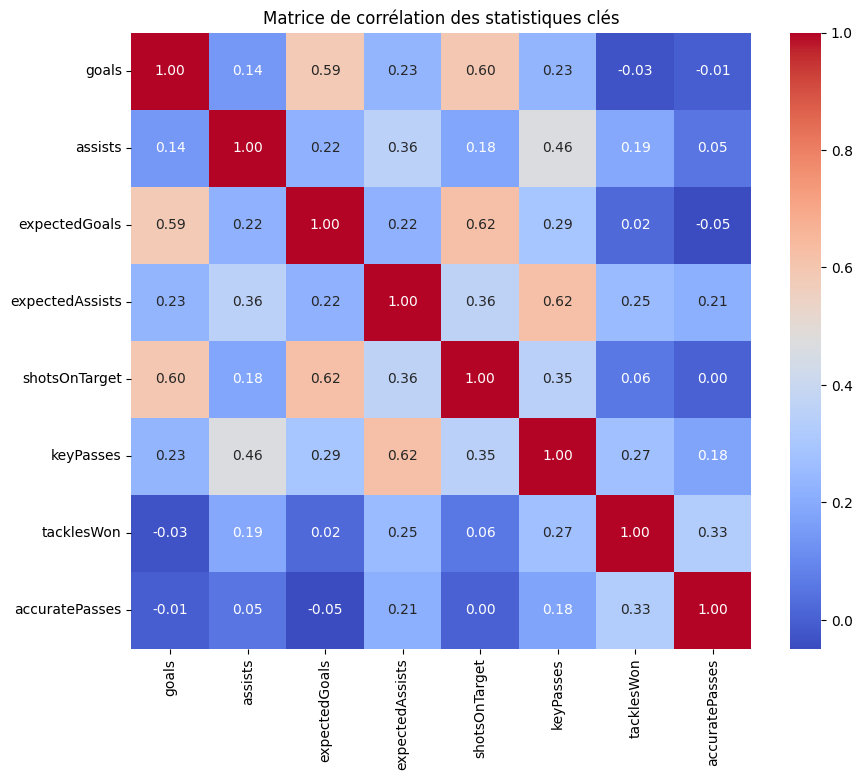

In [825]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que df soit votre DataFrame principal
# Sélection d'un sous-ensemble de colonnes numériques pertinentes
stats = ['goals', 'assists', 'expectedGoals', 'expectedAssists', 'shotsOnTarget', 'keyPasses', 'tacklesWon', 'accuratePasses']


plt.figure(figsize=(10,8))
corr = df_fusion_players[stats].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation des statistiques clés")
plt.show()

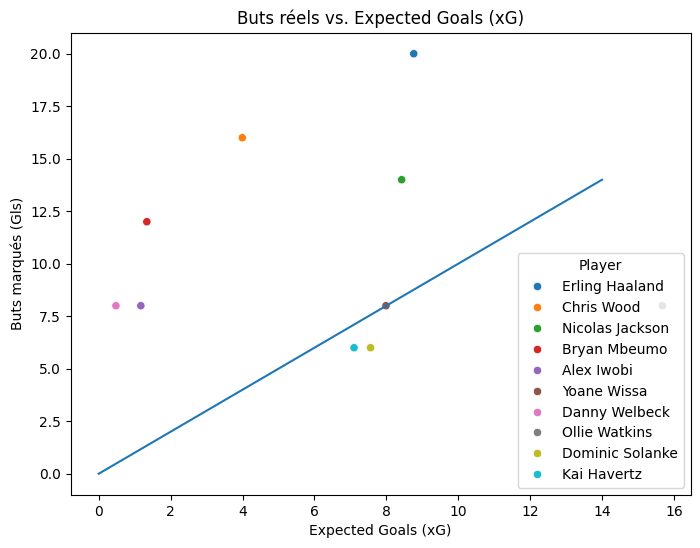

In [824]:
import numpy as np

plt.figure(figsize=(8,6))

sns.scatterplot(x='expectedGoals', y='goals', hue='Player', data=df_fusion_players,hue_order=df_fusion_players.sort_values(by='goals',ascending=False).index[:10])
plt.plot(np.arange(15),np.arange(15))
plt.title("Buts réels vs. Expected Goals (xG)")
plt.xlabel("Expected Goals (xG)")
plt.ylabel("Buts marqués (Gls)")
plt.show()

In [ ]:
list(df_fusion_players.columns)

In [852]:
import numpy as np
import matplotlib.pyplot as plt






    


categories = ['shotsOnTarget', 'accuratePasses', 'successfulDribbles', 'tacklesWon', 'totalDuelsWon']

max_categories=dict([(x,(df_fusion_players.loc[:,x].max())) for x in categories])
mean_categories=dict([(x,(df_fusion_players.loc[:,x].mean())) for x in categories])

def polygone(joueur):
    
    values = [(df_fusion_players.loc[joueur,c]/mean_categories[c]) for c in categories]

    values += values[:1]

    N = len(categories)

    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]


    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_ylim(0, max(values))

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, color='black', size=12)

    
    ax.plot(angles, values, color='limegreen', linewidth=2)
    ax.fill(angles, values, color='limegreen', alpha=0.25)

    ax.set_title(f"Radar de {joueur}", size=14, pad=20)

    plt.show()

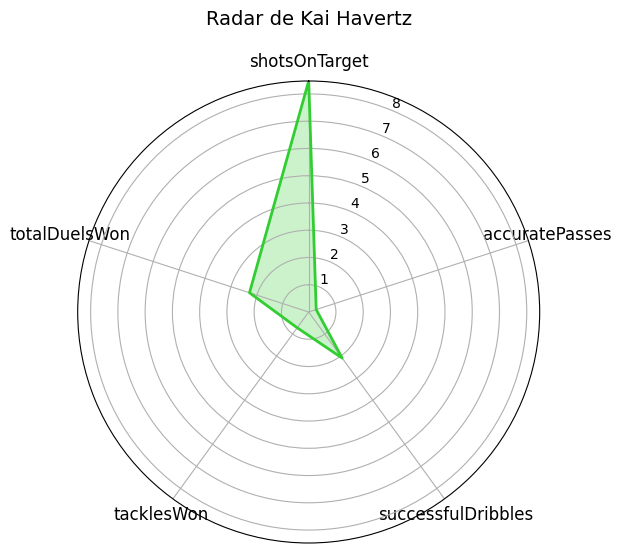

In [856]:
polygone('Kai Havertz')